# Exercise 29 Solution - Generative adversarial network

### Task
Train a generative adversarial network (on a dataset composed of circles) and use the discriminator as anomaly detector (using a dataset composed of squares, triangles or crosses)

### Learning goals
- Understand the generative adversarial network architecture and its training procedure
- Familiarize yourself with the implementation
- Use the discriminator of a generative adversarial network for anomaly detection

In [1]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)
np.random.seed(0)
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')

## Hyperparameters

**data generation parameters**

In [3]:
N = 64
domainLength = 1
numberOfCircles = 5
radius = 0.12
min_max_side_length = (0.8, 0.8)

numberOfSamples = 1280  # 640? #1280
numberOfAnomolousSamples = 128

**neural network parameters**

In [4]:
# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator, ndf//2 to stabilize training
ndf = ngf // 2

**training parameters**

In [5]:
workers = 1  # Number of workers for dataloader
batch_size = 16
num_epochs = 5
lr = 2e-4
beta1 = 0.5

ngpu = 1  # Number of GPUs available. Use 0 for CPU mode.

## Data generation

**helper functions to generate shapes**

In [6]:
def draw_circle(N, domainLength, x_center, y_center, diameter):
    domain = np.ones((N, N))
    radius = diameter / 2
    x = np.linspace(0, domainLength, N)
    y = np.linspace(0, domainLength, N)
    X, Y = np.meshgrid(x, y)
    mask = (X - x_center) ** 2 + (Y - y_center) ** 2 <= radius ** 2
    domain[mask] = -1
    return domain


def draw_square(N, domainLength, x_center, y_center, side_length):
    domain = np.ones((N, N))
    x = np.linspace(0, domainLength, N)
    y = np.linspace(0, domainLength, N)
    X, Y = np.meshgrid(x, y)
    mask = (np.abs(X - x_center) <= side_length / 2) & (np.abs(Y - y_center) <= side_length / 2)
    domain[mask] = -1
    return domain


def draw_triangle(N, domainLength, x_center, y_center, height):
    domain = np.ones((N, N))
    x = np.linspace(0, domainLength, N)
    y = np.linspace(0, domainLength, N)
    X, Y = np.meshgrid(x, y)

    # Height of the equilateral triangle
    side_length = 2 / np.sqrt(3) * height

    # Calculate vertices of the triangle
    v_top = (x_center, y_center - 2 * height / 3)  # Top vertex
    v_left = (x_center - side_length / 2, y_center + height / 3)  # Bottom left vertex
    v_right = (x_center + side_length / 2, y_center + height / 3)  # Bottom right vertex

    # Create mask for points inside the triangle using cross products
    mask = (
            ((X - v_top[0]) * (v_left[1] - v_top[1]) - (Y - v_top[1]) * (v_left[0] - v_top[0]) >= 0) &
            ((X - v_left[0]) * (v_right[1] - v_left[1]) - (Y - v_left[1]) * (v_right[0] - v_left[0]) >= 0) &
            ((X - v_right[0]) * (v_top[1] - v_right[1]) - (Y - v_right[1]) * (v_top[0] - v_right[0]) >= 0)
    )

    domain[mask] = -1
    return domain


def draw_cross(N, domainLength, x_center, y_center, arm_length):
    domain = np.ones((N, N))
    x = np.linspace(0, domainLength, N)
    y = np.linspace(0, domainLength, N)
    X, Y = np.meshgrid(x, y)

    arm_width = arm_length / 3

    # Create masks for the vertical and horizontal bars of the cross
    vertical_bar = (np.abs(X - x_center) <= arm_width / 2) & (np.abs(Y - y_center) <= arm_length / 2)
    horizontal_bar = (np.abs(X - x_center) <= arm_length / 2) & (np.abs(Y - y_center) <= arm_width / 2)

    # Combine the masks to form the cross
    mask = vertical_bar | horizontal_bar
    domain[mask] = -1
    return domain


# Function to generate either a circle, a square or a triangle
def generate_shapes(N, domainLength, min_max_side_length, shape=None):
    if shape is None:
        shape = np.random.randint(0, 4)  # Random shape type between 0 and 3

    if shape == 0:  # Circle
        diameter = np.random.uniform(*min_max_side_length)
        x_center = np.random.uniform(diameter / 2, domainLength - diameter / 2)
        y_center = np.random.uniform(diameter / 2, domainLength - diameter / 2)
        domain = draw_circle(N, domainLength, x_center, y_center, diameter)

    elif shape == 1:  # Square
        side_length = np.random.uniform(*min_max_side_length)
        x_center = np.random.uniform(side_length / 2, domainLength - side_length / 2)
        y_center = np.random.uniform(side_length / 2, domainLength - side_length / 2)
        domain = draw_square(N, domainLength, x_center, y_center, side_length)

    elif shape == 2:  # Triangle
        height = np.random.uniform(*min_max_side_length)
        side_length = 2 / np.sqrt(3) * height
        x_center = np.random.uniform(side_length / 2, domainLength - side_length / 2)
        y_center = np.random.uniform(side_length / 2, domainLength - side_length / 2)
        domain = draw_triangle(N, domainLength, x_center, y_center, height)

    else:  # Cross
        arm_length = np.random.uniform(*min_max_side_length)
        x_center = np.random.uniform(arm_length / 2, domainLength - arm_length / 2)
        y_center = np.random.uniform(arm_length / 2, domainLength - arm_length / 2)
        domain = draw_cross(N, domainLength, x_center, y_center, arm_length)

    return domain, shape

**data generation**

In [7]:
circles = np.zeros((numberOfSamples, 1, N, N))
shapes = np.zeros((numberOfSamples, 1))
for k in range(numberOfSamples):
    domain, shape = generate_shapes(N, domainLength, min_max_side_length, 0)
    circles[k, 0] = domain
    shapes[k] = shape
torch.save(torch.from_numpy(circles).to(torch.float32), f"data/circleData{N}.pt")
torch.save(torch.from_numpy(shapes).to(torch.float32), f"data/circleLabels{N}.pt")

squares = np.zeros((numberOfSamples, 1, N, N))
shapes = np.zeros((numberOfSamples, 1))
for k in range(numberOfSamples):
    domain, shape = generate_shapes(N, domainLength, min_max_side_length, 1)
    squares[k, 0] = domain
    shapes[k] = shape
torch.save(torch.from_numpy(squares).to(torch.float32), f"data/squareData{N}.pt")
torch.save(torch.from_numpy(shapes).to(torch.float32), f"data/squareLabels{N}.pt")

triangles = np.zeros((numberOfSamples, 1, N, N))
shapes = np.zeros((numberOfSamples, 1))
for k in range(numberOfSamples):
    domain, shape = generate_shapes(N, domainLength, min_max_side_length, 2)
    triangles[k, 0] = domain
    shapes[k] = shape
torch.save(torch.from_numpy(triangles).to(torch.float32), f"data/triangleData{N}.pt")
torch.save(torch.from_numpy(shapes).to(torch.float32), f"data/triangleLabels{N}.pt")

crosses = np.zeros((numberOfSamples, 1, N, N))
shapes = np.zeros((numberOfSamples, 1))
for k in range(numberOfSamples):
    domain, shape = generate_shapes(N, domainLength, min_max_side_length, 3)
    crosses[k, 0] = domain
    shapes[k] = shape
torch.save(torch.from_numpy(crosses).to(torch.float32), f"data/crossData{N}.pt")
torch.save(torch.from_numpy(shapes).to(torch.float32), f"data/crossLabels{N}.pt")

**visualization of each shape**

(1280, 1, 64, 64)
(1280, 1, 64, 64)
(1280, 1, 64, 64)
(1280, 1, 64, 64)


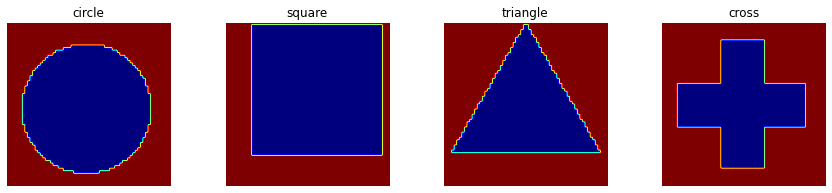

In [8]:
labels = ['circle', 'square', 'triangle', 'cross']
samples_list = [circles, squares, triangles, crosses]
fig, axes = plt.subplots(1, 4, figsize=(15, 3))
for i, ax in enumerate(axes):
    print(samples_list[i].shape)
    sample = samples_list[i][1].squeeze()
    ax.imshow(sample, cmap='jet')
    ax.set_title(f'{labels[i]}')
    ax.axis('off')

## Dataset definition

**load generated data into PyTorch dataset**

In [9]:
class microstructureDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

**dataset instantiation**

In [10]:
data = torch.load('data/circleData64.pt', weights_only=False)
dataset = microstructureDataset(data[1:12800])
dataloader = DataLoader(dataset, batch_size=batch_size,
                        shuffle=True)

**visualization of some training samples**

torch.Size([16, 1, 64, 64])


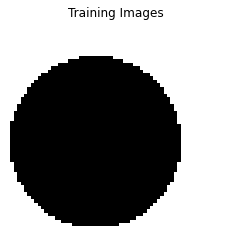

In [11]:
real_batch = next(iter(dataloader))
print(real_batch.shape)
plt.figure()
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

## Neural network architecture definition

**generator**

In [12]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.LeakyReLU(0.2, True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(0.2, True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

**discriminator**

In [13]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

**weight initialization**

In [14]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Training

**generator instantiation**

In [15]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)
print("number of parameters: " + str(sum([p.numel() for p in netG.parameters()])))

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): ConvTrans

**discriminator instantiation**

In [16]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)
print("number of parameters: " + str(sum([p.numel() for p in netD.parameters()])))

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)
number of parameters: 693632


**loss and optimizer**

In [17]:
criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

**TODO moritz**

In [18]:
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

**training loop**

In [19]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1


Starting Training Loop...
[0/5][0/80]	Loss_D: 1.2188	Loss_G: 2.0255	D(x): 0.5235	D(G(z)): 0.4061 / 0.1381
[0/5][50/80]	Loss_D: 0.0336	Loss_G: 6.9720	D(x): 0.9803	D(G(z)): 0.0132 / 0.0020
[1/5][0/80]	Loss_D: 0.2093	Loss_G: 8.2967	D(x): 0.9790	D(G(z)): 0.1226 / 0.0004
[1/5][50/80]	Loss_D: 0.1429	Loss_G: 2.5382	D(x): 0.8793	D(G(z)): 0.0043 / 0.1303
[2/5][0/80]	Loss_D: 0.5902	Loss_G: 7.5893	D(x): 0.9967	D(G(z)): 0.4026 / 0.0008
[2/5][50/80]	Loss_D: 0.0528	Loss_G: 5.8974	D(x): 0.9587	D(G(z)): 0.0099 / 0.0035
[3/5][0/80]	Loss_D: 0.0235	Loss_G: 5.6373	D(x): 0.9878	D(G(z)): 0.0111 / 0.0051
[3/5][50/80]	Loss_D: 0.0242	Loss_G: 5.9804	D(x): 0.9901	D(G(z)): 0.0139 / 0.0030
[4/5][0/80]	Loss_D: 0.0163	Loss_G: 6.2759	D(x): 0.9943	D(G(z)): 0.0105 / 0.0024
[4/5][50/80]	Loss_D: 0.0098	Loss_G: 6.2564	D(x): 0.9972	D(G(z)): 0.0070 / 0.0025


## Post-processing

**training history**

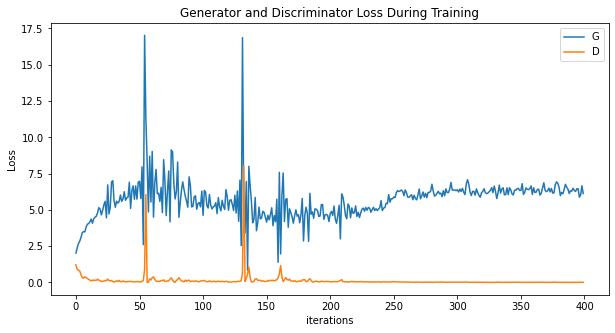

In [21]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**TODO moritz** WHAT IS THIS?

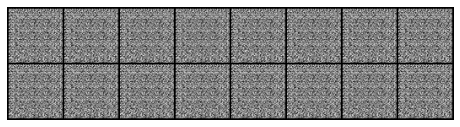

In [22]:
fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

**Visualization of a real sample**

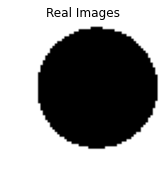

In [23]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure()
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(), (1, 2, 0)))
plt.show()

**Visualization of a fake sample** TODO WHAT IS THIS?

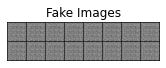

In [25]:
# Plot the fake images from the last epoch
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
plt.show()

**Discriminator prediction on a anomolous datapoint**

Discriminator: 0.00020020616648253053


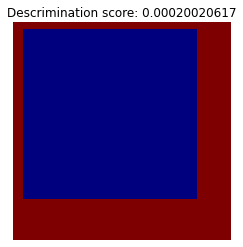

In [34]:
# load squared data
false_data = torch.load('data/squareData64.pt', weights_only=False)
false_dataset = microstructureDataset(false_data[1:12800])

false_batch = false_dataset[1:16].to(device)
descrimination = netD(false_batch).detach().cpu().numpy()
print("Discriminator: " + str(descrimination[0].item()))

# plot false batch and write descrimination in title
plt.figure()
plt.axis("off")
plt.title(f"Descrimination score: " + str(descrimination[0].squeeze()))
plt.imshow(np.transpose(false_batch[0].cpu(), (1, 2, 0)), cmap='jet')
plt.show()

**Discriminator prediction on a normal datapoint**

Discriminator: 0.9978598952293396


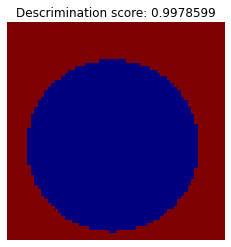

In [33]:
real_batch = next(iter(dataloader))
descrimination = netD(real_batch.to(device)).detach().cpu().numpy()
print("Discriminator: " + str(descrimination[0].item()))

plt.figure()
plt.axis("off")
plt.title(f"Descrimination score: " + str(descrimination[0].squeeze()))
plt.imshow(np.transpose(real_batch[0].cpu(), (1, 2, 0)), cmap='jet')
plt.show()